In [1]:
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import spacy
from spacy.training import Corpus

import os
import numpy as np

In [2]:
LEAST_CONF_MDIR = "../runs/least_confidence_50i_50n_kpwr-full_1669041142f2942019/models"
LEAST_CONF_MNAMES = [
    "model_2it_97spans.spacy",
    "model_14it_1020spans.spacy",
    "model_27it_2016spans.spacy",
    "model_41it_3040spans.spacy"
]
LEAST_CONF_CLS_DISTRIB = [
    {"nam_liv_person": 44, "nam_loc_gpe_city": 19, "nam_loc_gpe_country": 34},
    {"nam_liv_person": 581, "nam_loc_gpe_city": 234, "nam_loc_gpe_country": 205},
    {"nam_liv_person": 1129, "nam_loc_gpe_city": 475, "nam_loc_gpe_country": 412},
    {"nam_liv_person": 1690, "nam_loc_gpe_city": 746, "nam_loc_gpe_country": 604}
]

In [3]:
RAND_MDIR = "../runs/random_50i_50n_kpwr-full_1669041088f13043/models"
RAND_MNAMES = [
    "model_2it_97spans.spacy",
    "model_14it_1023spans.spacy",
    "model_27it_2007spans.spacy",
    "model_40it_3005spans.spacy"
]
RAND_CLS_DISTRIB = [
    {"nam_liv_person": 44, "nam_loc_gpe_city": 19, "nam_loc_gpe_country": 34},
    {"nam_liv_person": 527, "nam_loc_gpe_city": 263, "nam_loc_gpe_country": 233},
    {"nam_liv_person": 1075, "nam_loc_gpe_city": 510, "nam_loc_gpe_country": 422},
    {"nam_liv_person": 1663, "nam_loc_gpe_city": 750, "nam_loc_gpe_country": 592}
]

In [4]:
TEST_DB = "../data/inzynierka-kpwr-test-3-full.spacy"
_temp_nlp = spacy.load(os.path.join(RAND_MDIR, RAND_MNAMES[0]))
test_corpus = tuple(Corpus(TEST_DB)(_temp_nlp))

In [5]:
SPANS_KEY = "sc"
label_idxs = {"nam_liv_person": 0, "nam_loc_gpe_city": 1,
                "nam_loc_gpe_country": 2, "O": 3}
 # order of labels in the confusion matrix
ticklabels = ["nam_liv_person", "nam_loc_gpe_city", "nam_loc_gpe_country", "O"]
short_labels = ["PERSON", "CITY", "COUNTRY", "O"]

def get_spans_confusion_matrix(test_corpus, predictions, spans_key, label_idxs):
    n_labels = len(label_idxs)
    cm = np.zeros(shape=(n_labels, n_labels))
    for actual, pred in zip(test_corpus, predictions):
        actual_spans = actual.to_dict()["doc_annotation"]["spans"]
        pred_spans = pred.spans
        if not actual_spans or not pred_spans:
            continue
        for actual_span in actual_spans[spans_key]:
            actual_label = actual_span[2]
            found = False
            for pred_span in pred_spans[spans_key]:
                if actual_span[0] == pred_span.start_char \
                        and actual_span[1] == pred_span.end_char:
                    pred_label = pred_span.label_
                    cm[label_idxs[actual_label]][label_idxs[pred_label]] += 1
                    found = True
            if not found:
                cm[label_idxs[actual_label]][label_idxs["O"]] += 1
    return cm

## Confusion matrixes comparison of sampling strategies models

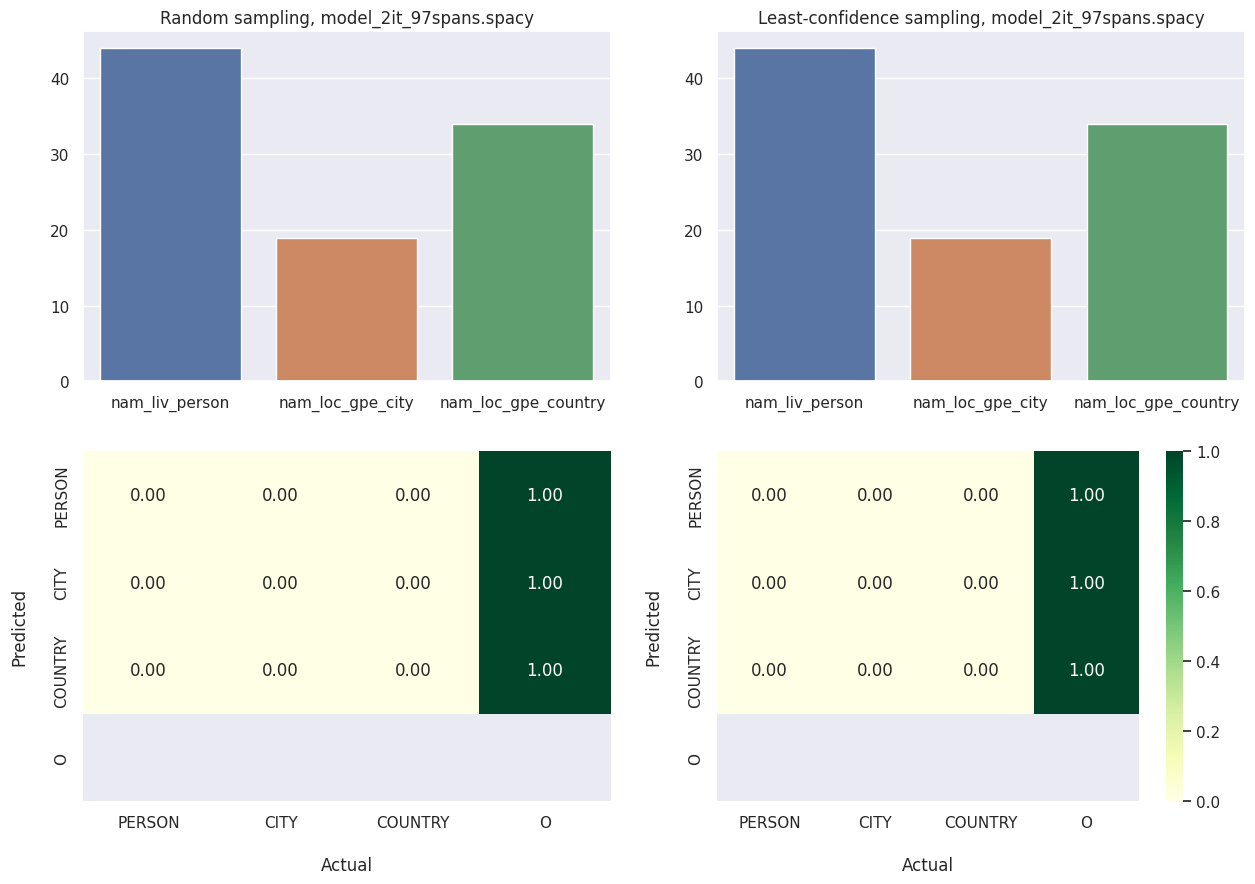

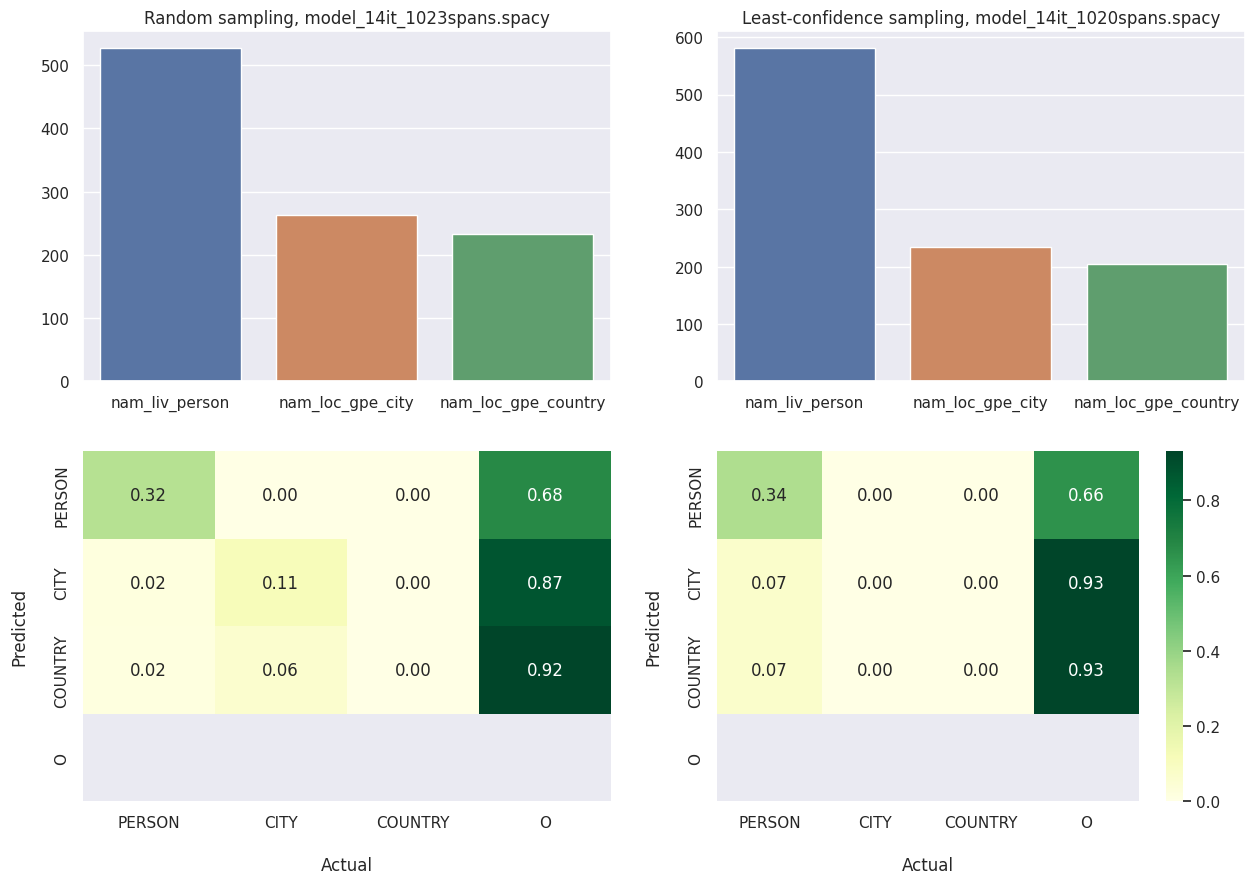

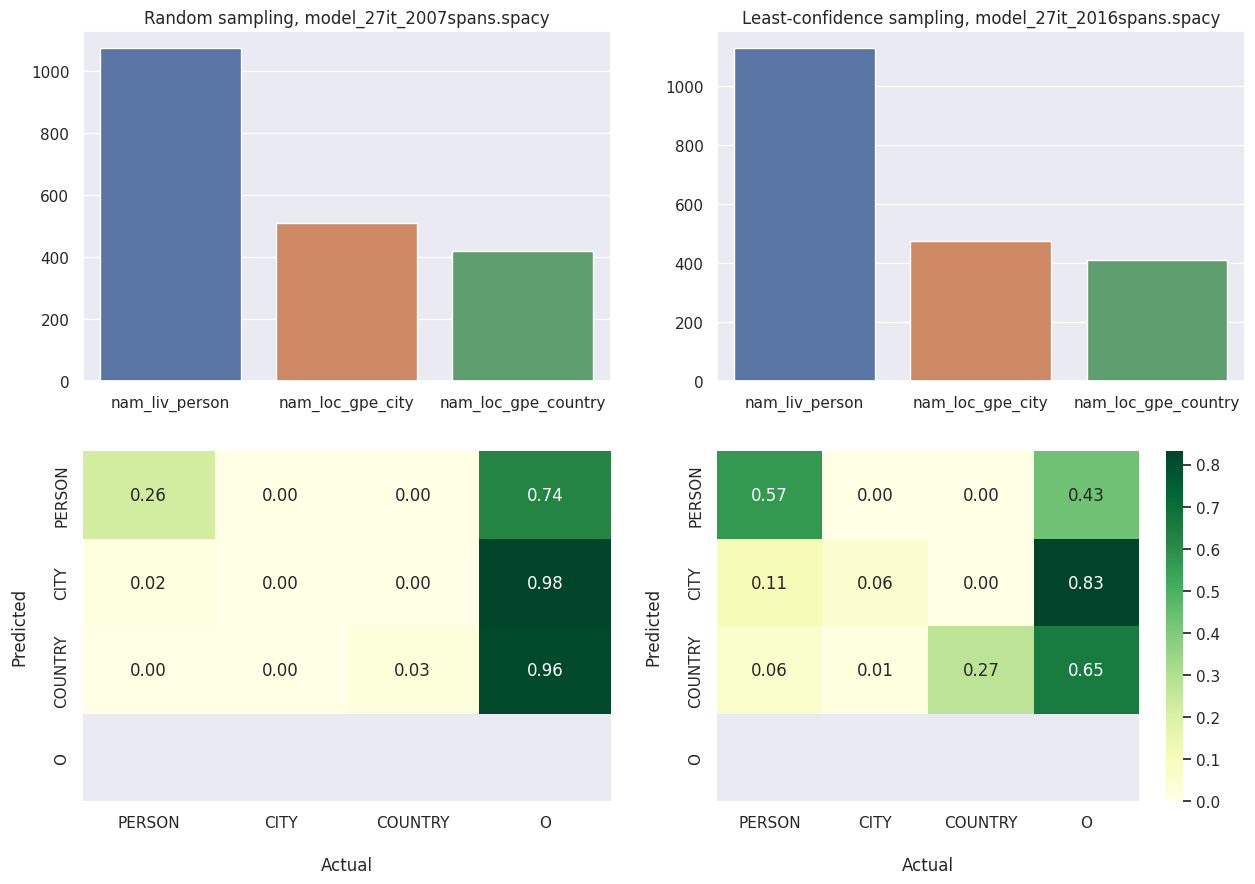

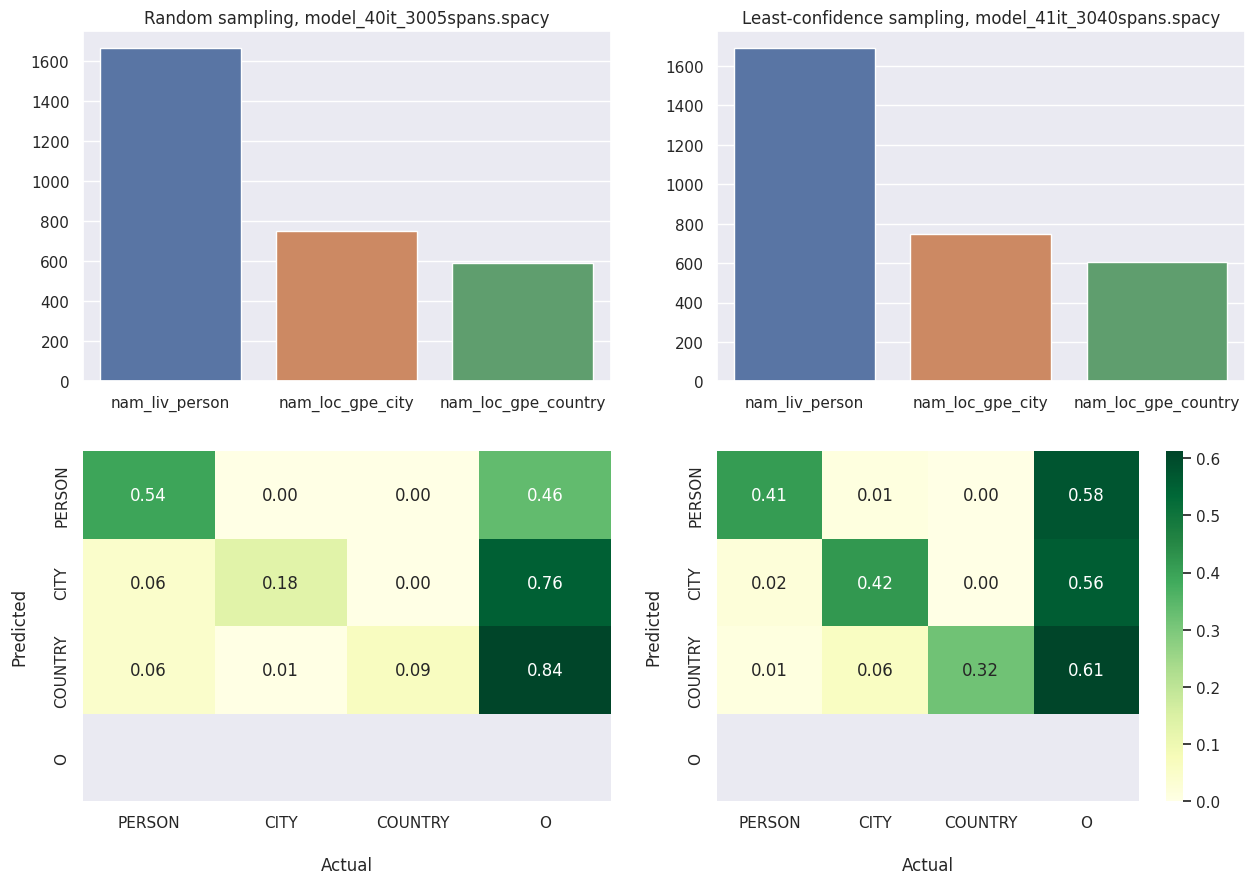

In [6]:
texts = [example.text for example in test_corpus]
for rand_mname, lconf_mname, rand_cls_dist, lconf_cls_dist in zip(
        RAND_MNAMES, LEAST_CONF_MNAMES,
        RAND_CLS_DISTRIB, LEAST_CONF_CLS_DISTRIB
):
    sn.set(font_scale=1)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    rand_classes = list(rand_cls_dist.keys())
    rand_counts = list(rand_cls_dist.values())
    rand_bar = sn.barplot(x=rand_classes, y=rand_counts, ax=axes[0,0])
    rand_bar.set(title=f"Random sampling, {rand_mname}")

    lconf_classes = list(lconf_cls_dist.keys())
    lconf_counts = list(lconf_cls_dist.values())
    lconf_bar = sn.barplot(x=lconf_classes, y=lconf_counts, ax=axes[0,1])
    lconf_bar.set(title=f"Least-confidence sampling, {lconf_mname}")

    rand_mpath = os.path.join(RAND_MDIR, rand_mname)
    rand_nlp = spacy.load(rand_mpath)
    rand_preds = rand_nlp.pipe(texts)
    rand_cm = get_spans_confusion_matrix(test_corpus, rand_preds,
                                         SPANS_KEY, label_idxs)
    rand_cm = rand_cm.astype('float') / rand_cm.sum(axis=1)[:, np.newaxis]
    rand_hm = sn.heatmap(rand_cm, ax=axes[1,0], annot=True, cmap="YlGn",
                         fmt="0.2f", xticklabels=short_labels, cbar=False,
                         yticklabels=short_labels)
    rand_hm.set(xlabel="\nActual", ylabel="Predicted\n")

    lconf_mpath = os.path.join(LEAST_CONF_MDIR, lconf_mname)
    lconf_nlp = spacy.load(lconf_mpath)
    lconf_preds = lconf_nlp.pipe(texts)
    lconf_cm = get_spans_confusion_matrix(test_corpus, lconf_preds,
                                          SPANS_KEY, label_idxs)
    lconf_cm = lconf_cm.astype('float') / lconf_cm.sum(axis=1)[:, np.newaxis]
    lconf_hm = sn.heatmap(lconf_cm, ax=axes[1,1], annot=True, cmap="YlGn",
                          fmt="0.2f", xticklabels=short_labels,
                          yticklabels=short_labels)
    lconf_hm.set(xlabel="\nActual", ylabel="Predicted\n")

    plt.show()